In [1]:
import os
os.chdir(path='../')
import scanpy as sc
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import STForte.helper as stfhelper
from STForte import STForteModel
from STForte.helper import mclust_R
from plotly.subplots import make_subplots
sc.set_figure_params(dpi=120, transparent=True, dpi_save=400, frameon=False, vector_friendly=False, format="pdf", fontsize=24)
trial_name = "trial-mouse_olfa_Visium"
plot_dir = f"./{trial_name}/plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
sc.settings.figdir = plot_dir
plt.rcParams['font.sans-serif'] = [
    'Helvetica',
    'Arial',
    'sans-serif',]
palette = px.colors.qualitative.Plotly

/home/poncey/miniconda3/envs/stforte_env/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py:47: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_fabric.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
Global seed set to 0


In [2]:
adata = sc.read_h5ad(f"./{trial_name}/outputs/stforte.h5ad")
crop = [17000, 20000, 12000, 15000]
adata

AnnData object with n_obs × n_vars = 918 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'STForte_Mask'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'STForte_ATTR', 'STForte_COMB', 'STForte_TOPO', 'spatial'
    layers: 'raw_count'

In [3]:
adata_sp = sc.read_h5ad(f"./{trial_name}/outputs/sp.h5ad")
adata_sp

AnnData object with n_obs × n_vars = 3535 × 300
    obs: 'spot_instance'
    obsm: 'SP_ATTR_FP', 'SP_COMB', 'SP_TOPO', 'spatial'
    obsp: 'A_STForte_conn', 'A_STForte_recon'

In [4]:
model = STForteModel.__load_from_saved_model__(f"./{trial_name}/models/STForteModel_mouse_olfa_10x")
model

In [5]:
n_clusters = 6
adata = mclust_R(adata, n_clusters, "mclust_STForte_ATTR", used_obsm="STForte_ATTR")
adata = mclust_R(adata, n_clusters, "mclust_STForte_TOPO", used_obsm="STForte_TOPO")
adata = mclust_R(adata, n_clusters, "mclust_STForte_COMB", used_obsm="STForte_COMB")

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.

/home/poncey/Experiments/STForte_experiments/STForte/helper/__cluster_helpers.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_add] = mclust_res
/home/poncey/Experiments/STForte_experiments/STForte/helper/__cluster_helpers.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_add] = mclust_res


/home/poncey/miniconda3/envs/stforte_env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


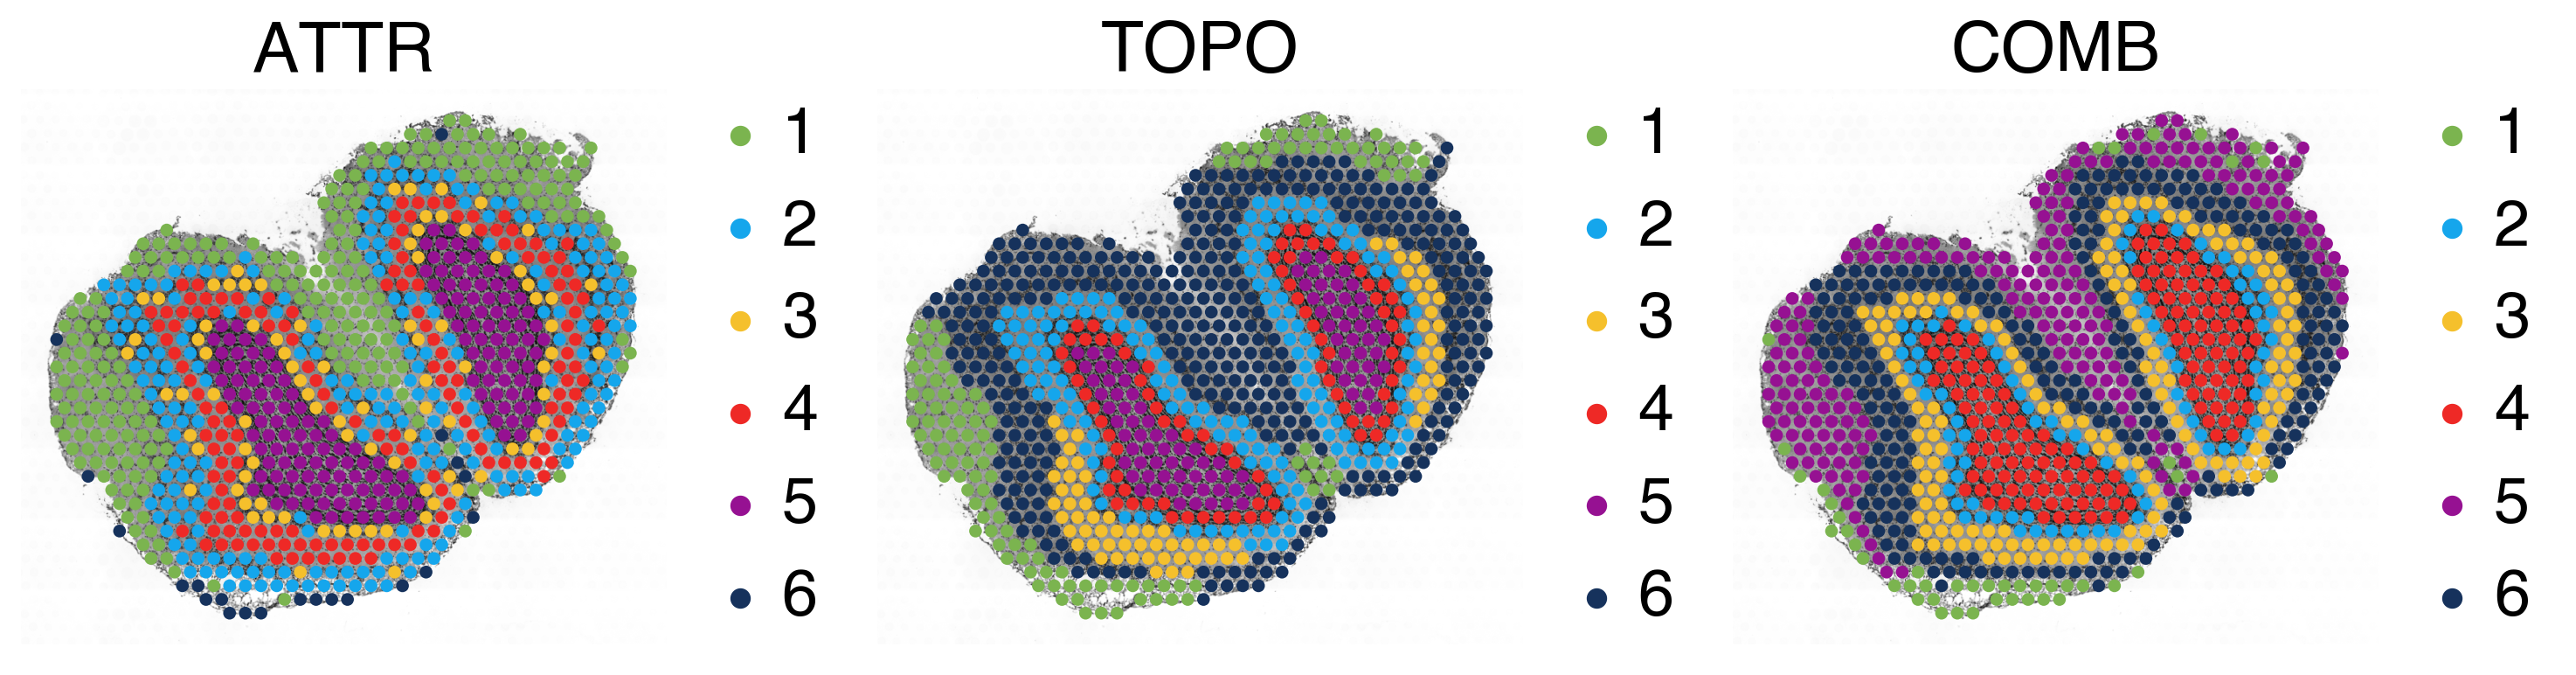

In [6]:
sc.pl.spatial(adata, color=["mclust_STForte_ATTR", "mclust_STForte_TOPO", "mclust_STForte_COMB"], img_key="hires", bw=True, size=1.25, frameon=False,
              title=["ATTR", "TOPO", "COMB"],
              palette=stfhelper.pl.prism_1960s_palette,
              save="_mclust_compare",
              )

In [7]:
for key in ["STForte_ATTR", "STForte_TOPO", "STForte_COMB"]:
    sc.pp.neighbors(adata, use_rep=f"{key}", key_added=f"STForte_{key}")
for key in ["STForte_ATTR", "STForte_TOPO", "STForte_COMB"]:
    adata.obsm[f"{key}_umap"] = sc.tl.umap(adata, neighbors_key=f"STForte_{key}", copy=True).obsm['X_umap']

In [8]:
fig = make_subplots(cols=3, rows=1)
for ii, key in enumerate(["STForte_ATTR", "STForte_TOPO", "STForte_COMB"]):
    for jj, cc in enumerate(adata.obs[f"mclust_{key}"].cat.categories):
        fig.add_trace(
            go.Scatter(
                x=adata[adata.obs[f"mclust_{key}"]==cc].obsm[f"{key}_umap"][:, 0],
                y=adata[adata.obs[f"mclust_{key}"]==cc].obsm[f"{key}_umap"][:, 1],
                mode="markers",
                marker_color=adata.uns[f'mclust_{key}_colors'][jj]
            ),
            row=1, col=ii+1
        )
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_layout(template="none", showlegend=False)
fig.write_image(f"{plot_dir}/umap_mclust_compare.pdf", width=1200, height=400)
fig.show()

In [9]:
base_label = "STForte_COMB"
for key in ["SP_TOPO", "SP_ATTR_FP", "SP_COMB"]:
    adata_sp.obs[f"mclust_{base_label}_pad_{key}"] = stfhelper.annotation_propagate(adata_sp, f"mclust_{base_label}", adata, latent_embed=key, copy=True)

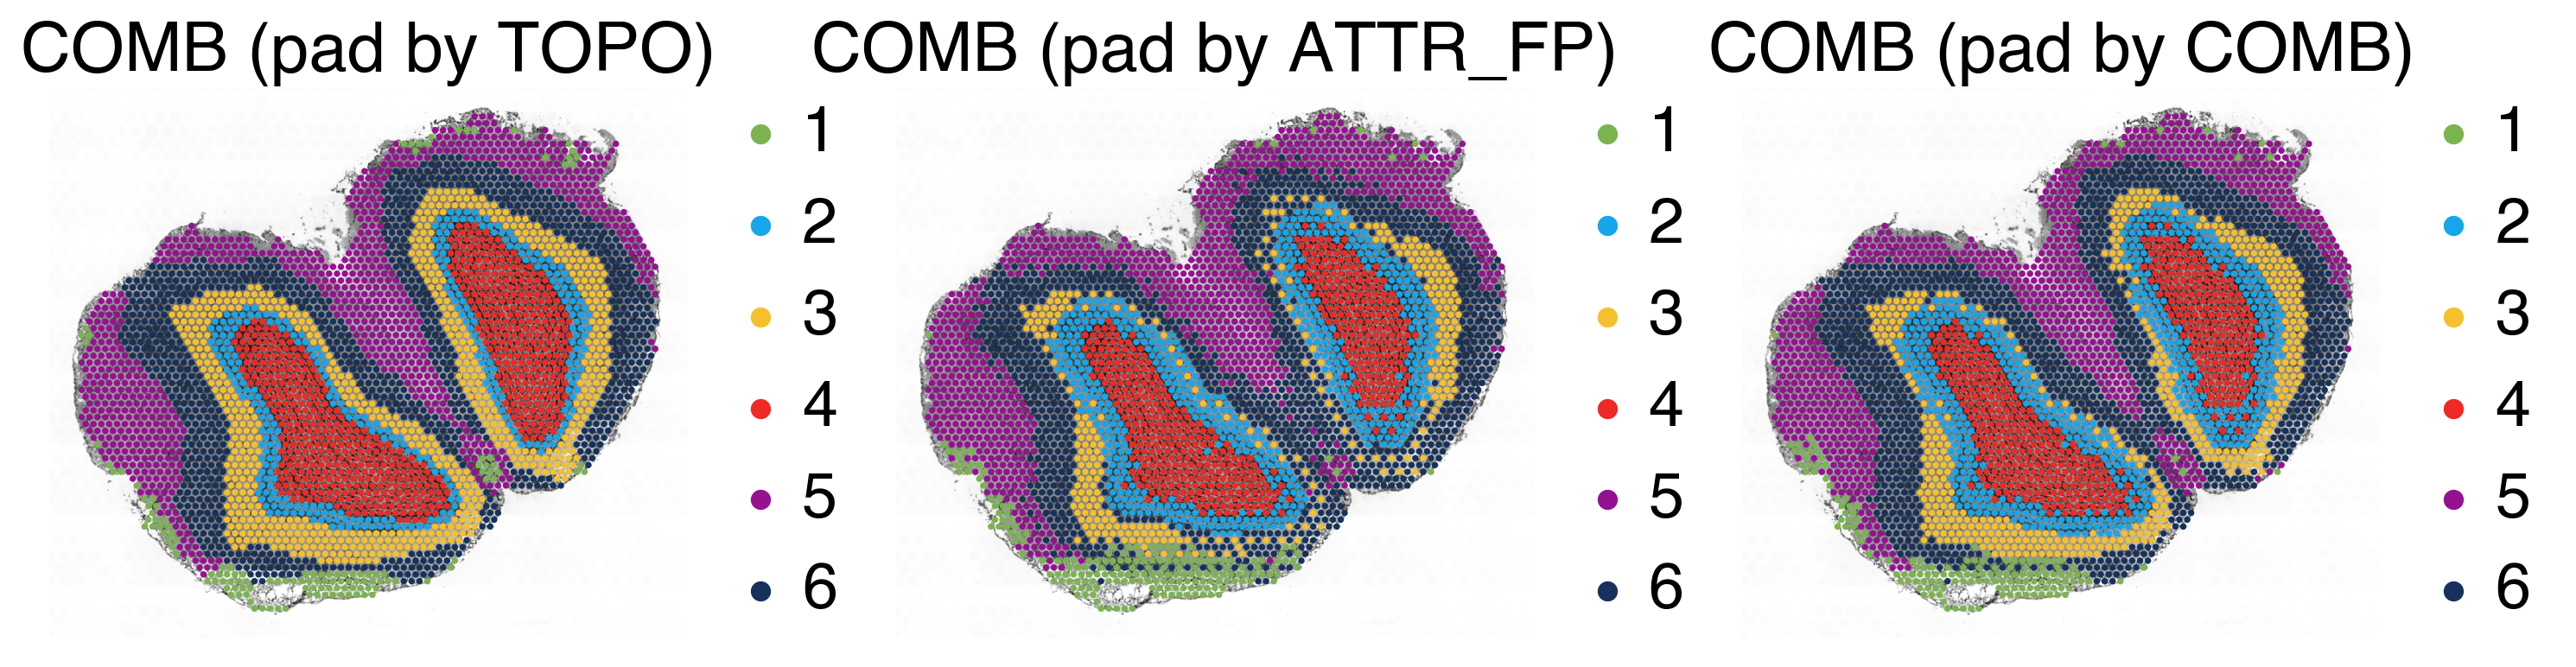

In [10]:
sc.pl.spatial(adata_sp, size=0.625, bw=True,
              color=[f'mclust_{base_label}_pad_SP_TOPO', f'mclust_{base_label}_pad_SP_ATTR_FP', f'mclust_{base_label}_pad_SP_COMB'], 
              title=[f'COMB (pad by TOPO)', f'COMB (pad by ATTR_FP)', f'COMB (pad by COMB)'],
              palette=stfhelper.pl.prism_1960s_palette,
              frameon=False,
              img=adata.uns['spatial']['stomic']['images']['hires'],
              spot_size=adata.uns['spatial']['stomic']['scalefactors']['spot_diameter_fullres'], 
              scale_factor=adata.uns['spatial']['stomic']['scalefactors']['tissue_hires_scalef'],
              save="_mclust_sp_compare")

In [11]:
for key in ["SP_ATTR_FP", "SP_TOPO", "SP_COMB"]:
    sc.pp.neighbors(adata_sp, use_rep=f"{key}", key_added=f"CONN_{key}")
for key in ["SP_ATTR_FP", "SP_TOPO", "SP_COMB"]:
    adata_sp.obsm[f"{key}_umap"] = sc.tl.umap(adata_sp, neighbors_key=f"CONN_{key}", copy=True).obsm['X_umap']

In [12]:
fig = make_subplots(cols=3, rows=1)
for ii, key in enumerate(["SP_TOPO", "SP_ATTR_FP", "SP_COMB"]):
    for jj, cc in enumerate(adata_sp.obs[f"mclust_{base_label}_pad_{key}"].cat.categories):
        fig.add_trace(
            go.Scatter(
                x=adata_sp[adata_sp.obs[f"mclust_{base_label}_pad_{key}"]==cc].obsm[f"{key}_umap"][:, 0],
                y=adata_sp[adata_sp.obs[f"mclust_{base_label}_pad_{key}"]==cc].obsm[f"{key}_umap"][:, 1],
                mode="markers",
                marker_color=adata_sp.uns[f'mclust_{base_label}_pad_{key}_colors'][jj],
                marker_size=4,
            ),
            row=1, col=ii+1
        )
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_layout(template="none", showlegend=False)
fig.write_image(f"{plot_dir}/umap_sp_pad_compare.pdf", width=1200, height=400)
fig.show()

In [13]:
fig = make_subplots(cols=3, rows=1)
for ii, key in enumerate(["SP_TOPO", "SP_ATTR_FP", "SP_COMB"]):
    for jj, cc in enumerate(adata_sp.obs[f"spot_instance"].cat.categories):
        fig.add_trace(
            go.Scatter(
                x=adata_sp[adata_sp.obs[f"spot_instance"]==cc].obsm[f"{key}_umap"][:, 0],
                y=adata_sp[adata_sp.obs[f"spot_instance"]==cc].obsm[f"{key}_umap"][:, 1],
                mode="markers",
                marker_color=stfhelper.pl.iwanthue_alphabet_hard[jj],
                name=cc,
                marker_size=4,
                showlegend=False if ii != 0 else True,
            ),
            row=1, col=ii+1
        )
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_layout(template="none", legend=dict(orientation="h",
    entrywidth=70,
    yanchor="bottom",
    y=-0.2,
    xanchor="center",
    x=0.5,
    itemsizing='constant'))
fig.write_image(f"{plot_dir}/umap_sp_instance_compare.pdf", width=1200, height=400)
fig.show()